## Random search compression on LeNet-5

In [1]:
import sys
sys.path.append('../')

In [2]:
import torch
import torch.nn as nn
import pandas as pd
import os
import math

from data.mnist import MnistDataset
from models.lenet.lenet import LeNet5
from utils.rnd import RandomController, Individual
from utils.train import *
from utils.weight_sharing import *
from utils.plot import *
from utils.fitness_controller import FitnessController

Setting parameters 

In [3]:
# net train settings
LEARNING_RATE = 0.0001
BATCH_SIZE = 32
N_CLASSES = 10
DEVICE = 'cpu'
EPOCHS = 100

# net save settings
NET_PATH = '../models/lenet/saves/lenet_relu.save'
NET_TYPE = 'relu'

# dataset settings
DATA_PATH = '../data'

# random search iter count
NUM_INDIVIDUALS = 400

# random search search settings
REPR_RANGES = [range(1, 11) for _ in range(5)]

# random search save settings
SAVE_RND_FILE = '../results/test_RND_save.csv'
SAVE_EVERY = 1

# range optimization settings
RANGE_OPTIMIZATION = True
RANGE_OPTIMIZATION_TRESHOLD = 0.97
RANGE_OPTIMIZATION_FILE = '../results/lenet-relu-layer-perf.csv'

# target position
TARGET = [1.0, 12.0]
TARGET_LOW_LIMIT = [0.95, 1.0]
LOCK_TARGET = False

# WS settings
SHARE_ORDER = [0, 1, 2, 3, 4]
RETRAIN_AMOUNT = None #[0, 0, 0, 0, 0]
PREC_REDUCT = None #['f4', 'f4', 'f4', 'f4', 'f4']
CLUST_MOD_FOCUS = None #[0, 0, 0, 0, 0]
CLUST_MOD_SPREAD = None #[0, 0, 0, 0, 0]

Geting somewhat trained LeNet-5

In [4]:
dataset = MnistDataset(BATCH_SIZE, DATA_PATH, val_split=0.5)
model = LeNet5(N_CLASSES, NET_TYPE)
model.to(DEVICE)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
train_settings = [criterion, optimizer, dataset, EPOCHS, DEVICE, 1, True]

get_trained(model, NET_PATH, train_settings, DEVICE)

before_loss = get_accuracy(model, dataset.test_dl, DEVICE)

Setting weight share controller

In [5]:
lam_opt = lambda mod : torch.optim.Adam(mod.parameters(), lr=LEARNING_RATE)
lam_train = lambda opt, epochs : train_net(model, criterion, opt, dataset, epochs, device=DEVICE)
lam_test = lambda : get_accuracy(model, dataset.test_dl, DEVICE)

ws_controller = WeightShare(model, lam_opt, lam_train, lam_test)
ws_controller.set_reset()

ws_controller.print_layers_info()

layer_name #weights #bias w_locked CR
feature_extractor.0 150 6 False 1.00
feature_extractor.3 2400 16 False 1.00
feature_extractor.6 48000 120 False 1.00
classifier.0 10080 84 False 1.00
classifier.2 840 10 False 1.00
Sum num weights, bias:  61470 236
Compression rate 1.00


Defining fitness function

In [6]:
def fitness_vals_fc(individual:Individual):
    # reset the net
    ws_controller.reset()
    
    # share weigts by particle
    if individual.data is None:
        individual.data = ws_controller.share(individual.representation, SHARE_ORDER, RETRAIN_AMOUNT, PREC_REDUCT, CLUST_MOD_FOCUS, CLUST_MOD_SPREAD)
    
    return [individual.data['accuracy'], individual.data['compression']]

def fit_from_vals(data, targ_vals):

    return 1 / math.sqrt(pow(1 - (data['accuracy'] - 0.9)/0.1, 2) + pow(1 - (data['compression']/targ_vals[1]), 2))

Defining logging

In [7]:
data = {
    'representation': [],
    'accuracy': [],
    'accuracy_loss': [],
    'compression': [],
    'share_t': [],
    'train_t': [],
    'acc_t': []
}

data_types = {
    'accuracy': 'float32',
    'accuracy_loss': 'float32',
    'compression': 'float32',
    'share_t': 'float32',
    'train_t': 'float32',
    'acc_t': 'float32'
}

rnd_data = pd.read_csv(SAVE_RND_FILE).astype(data_types) if os.path.exists(SAVE_RND_FILE) else pd.DataFrame(data).astype(data_types)

def logger_fc(rnd_controler:RandomController):
    global rnd_data

    new_data = copy.deepcopy(data)

    indiv = rnd_controler.current_indiv

    new_data['representation'].append(indiv.representation)
    new_data['accuracy'].append(indiv.data['accuracy'])
    new_data['accuracy_loss'].append(before_loss - indiv.data['accuracy'])
    new_data['compression'].append(indiv.data['compression'])
    new_data['share_t'].append(indiv.data['times']['share'])
    new_data['train_t'].append(indiv.data['times']['train'])
    new_data['acc_t'].append(indiv.data['times']['test'])

    # saving progress
    rnd_data = rnd_data.append(pd.DataFrame(new_data).astype(data_types))
    rnd_data.reset_index(drop=True, inplace=True)
    os.makedirs(os.path.dirname(SAVE_RND_FILE), exist_ok=True)
    rnd_data.to_csv(SAVE_RND_FILE, index=False)

Setting ranges with optimization

In [8]:
lam_test_inp = lambda _ : get_accuracy(model, dataset.test_dl, DEVICE)

if RANGE_OPTIMIZATION:
    REPR_RANGES = ws_controller.get_optimized_layer_ranges(REPR_RANGES, lam_test_inp, RANGE_OPTIMIZATION_TRESHOLD, 
        savefile=RANGE_OPTIMIZATION_FILE)

for repr_range in REPR_RANGES:
    print(len(repr_range))

49
47
47
48
47


Running the search

In [9]:
fit_controll = FitnessController(TARGET, fitness_vals_fc, fit_from_vals, target_max_offset=1, lock=LOCK_TARGET, target_limit=TARGET_LOW_LIMIT)
random = RandomController(REPR_RANGES, fit_controll)

if rnd_data.size != 0:
    random.load_from_pd(rnd_data, True)

random.run(NUM_INDIVIDUALS, logger_fc, verbose = True)

[[0.9846    5.8347588]
 [0.9846    4.7756486]
 [0.985     5.3009057]
 [0.9852    4.9692183]
 [0.9862    5.170593 ]
 [0.9762    7.417126 ]
 [0.9736    8.0313   ]
 [0.974     6.027611 ]
 [0.979     8.968766 ]
 [0.984     5.3934817]]
[[0.9836, 6.634841901112805]]
Individual 1/10 (10) evaluated Individual ([6, 19, 41, 8, 45]) fit:2.0998429600105784
[[0.985, 4.923945296532855]]
Individual 2/10 (11) evaluated Individual ([49, 30, 27, 38, 20]) fit:1.6435187527823005
[[0.983, 5.943908628812897]]
Individual 3/10 (12) evaluated Individual ([30, 23, 6, 44, 23]) fit:1.8778022282894142
[[0.9832, 6.922999752194903]]
Individual 4/10 (13) evaluated Individual ([27, 6, 15, 21, 10]) fit:2.196749175578725
[[0.9852, 4.80965279850865]]
Individual 5/10 (14) evaluated Individual ([37, 41, 35, 10, 48]) fit:1.620212848947251
[[0.9848, 5.682837089455132]]
Individual 6/10 (15) evaluated Individual ([15, 21, 30, 22, 18]) fit:1.8250338817150777
[[0.9842, 5.482836477167063]]
Individual 7/10 (16) evaluated Individua

[27, 4, 49, 3, 23]

See output

In [10]:
rnd_data

,representation,accuracy,accuracy_loss,compression,share_t,train_t,acc_t,fitness
0,"[33, 49, 8, 23, 24]",0.9846,0.0000,5.834759,1.015224,0.0,4.704812,1.0
1,"[34, 18, 32, 39, 42]",0.9846,0.0000,4.775649,1.717755,0.0,3.902231,1.0
2,"[38, 27, 37, 25, 14]",0.9850,-0.0004,5.300906,1.478786,0.0,3.647128,1.0
3,"[18, 20, 26, 47, 50]",0.9852,-0.0006,4.969218,1.391554,0.0,3.527671,1.0
4,"[24, 48, 29, 14, 48]",0.9862,-0.0016,5.170593,1.308849,0.0,3.585720,1.0
5,"[50, 14, 32, 3, 19]",0.9762,0.0084,7.417126,1.249218,0.0,3.684242,2.0
6,"[46, 14, 4, 9, 16]",0.9736,0.0110,8.031300,0.603802,0.0,3.480892,2.0
7,"[27, 5, 44, 18, 22]",0.9740,0.0106,6.027611,1.731914,0.0,3.568015,1.0
8,"[27, 4, 49, 3, 23]",0.9790,0.0056,8.968766,1.712488,0.0,3.576031,3.0
9,"[46, 34, 12, 44, 12]",0.9840,0.0006,5.393482,1.104451,0.0,3.721330,1.0


Plotting data

Text(0.5, 1.0, 'Random search on LeNet-5')

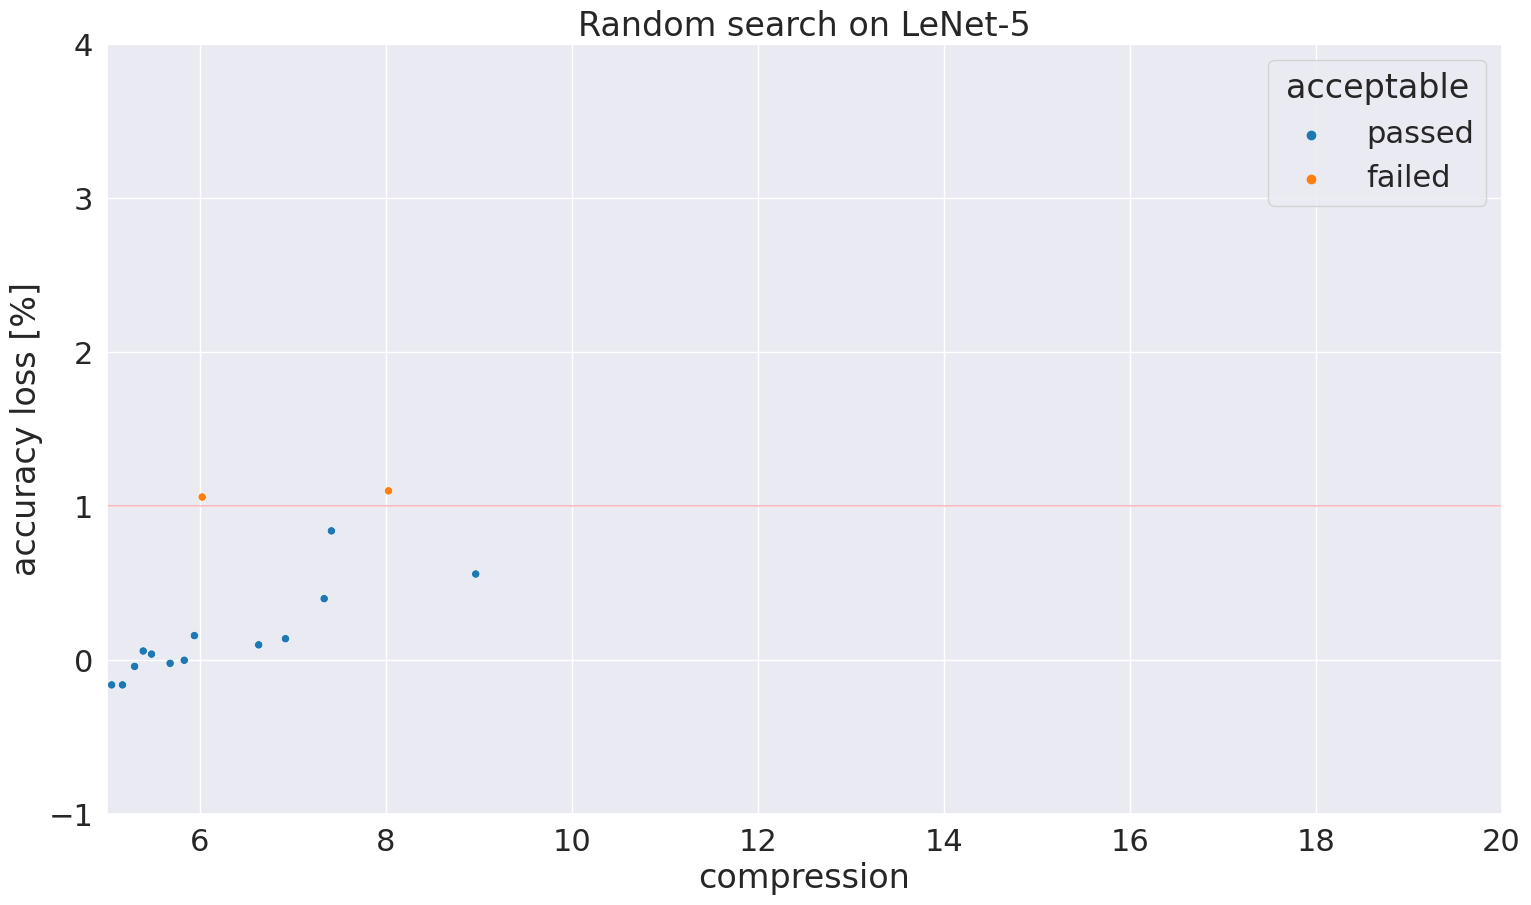

In [11]:
plot_alcr(rnd_data)
plt.title('Random search on LeNet-5')

In [12]:
fit_controll.targ

array([ 1., 12.])